# Descripcion de la tarea
El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces. Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.

## Objetivos.
El objetivo primordial es identificar operadores ineficaces. Para ello hay que evaluar el desempeño de los operadores, esto se hará principalmente de acuerdo a los factores siguientes:

- Cantidad de llamadas entrantes perdidas.
- Tiempo de espera.
- Cantidad de llamadas totales.
- Duración de las llamadas.

Los umbrales para evaluar los estableceré al observar la distribución de los datos en cada caso.

Luego de obtener los resultados probaré disitintas hipótesis para intentar explicar el comportamiento en general y con ello poder ofrecer conclusiones acordes.

## Tablas y librerías

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import levene, mannwhitneyu, f_oneway

In [2]:
clients = pd.read_csv('/datasets/telecom_clients_us.csv')
telecom = pd.read_csv('/datasets/telecom_dataset_us.csv')

## EDA y Preprocesamiento

### Clients

In [3]:
clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [4]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


In [5]:
clients['date_start'] = pd.to_datetime(clients['date_start'], format = '%Y-%m-%d')

In [6]:
clients[clients.duplicated()]

,user_id,tariff_plan,date_start


### Telecom

In [7]:
telecom.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [8]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [9]:
telecom['date'] = pd.to_datetime(telecom['date'], errors='coerce')
telecom['date'] = telecom['date'].dt.tz_localize(None)

In [10]:
telecom[telecom.duplicated()]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
8,166377,2019-08-05,out,False,880020.0,True,8,0,50
28,166377,2019-08-12,in,False,NaN,True,2,0,34
44,166377,2019-08-14,out,False,880026.0,False,10,1567,1654
45,166377,2019-08-14,in,False,NaN,True,1,0,3
51,166377,2019-08-15,out,False,880026.0,False,11,1413,1473
...,...,...,...,...,...,...,...,...,...
53869,168601,2019-11-25,in,False,952914.0,False,7,1229,1282
53874,168601,2019-11-26,in,False,952914.0,False,4,539,562
53875,168601,2019-11-26,in,False,NaN,True,3,0,35
53885,168603,2019-11-20,out,False,959118.0,True,3,0,89


In [11]:
telecom = telecom.drop_duplicates()

En la columna 'operator_id' hay muchos nulos por lo que no es posible saber a que operador se refieren esas entradas o si son varios. Sin embargo tiene información relevante en las demás entradas así que lo trataré como un operador ficticio bajo el número 999 para poder utilizar los datos(luego de comprobar que no existe ese operador).

In [12]:
telecom[telecom['operator_id']==999]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration


In [13]:
telecom['operator_id'].fillna(999, inplace=True)

## Analisis

### Conteo llamadas perdidas

Evaluaremos eficiencia de cada operador respecto a solo las llamadas perdidas recibidas ya que no tienen control sobre si los clientes atienden al ser llamados. Si hay operadores fuera de esta lista recibirán un buena calificación pues no puede decirse que lo hicieron mal.

In [14]:
missed_calls = telecom[telecom['direction'] == 'in']
missed_calls = missed_calls.pivot_table(index='operator_id', columns='is_missed_call', aggfunc='size').reset_index()
missed_calls.head()

is_missed_call,operator_id,False,True
0,999.0,68.0,7202.0
1,879896.0,21.0,NaN
2,879898.0,57.0,NaN
3,880020.0,7.0,NaN
4,880022.0,8.0,NaN


Un valor núlo en esta tabla significa que no existen llamadas perdidas/atendidas en la columna respectiva asi que los reemplazo con 0

In [15]:
missed_calls.fillna(0, inplace=True)

In [16]:
missed_calls['miss_percent'] = ((missed_calls[True] / (missed_calls[False] + missed_calls[True])) * 100).round(3)

Observo los resultados

In [17]:
missed_calls['miss_percent'].describe()

count    755.000000
mean       3.835318
std        9.102239
min        0.000000
25%        0.000000
50%        0.000000
75%        3.846000
max      100.000000
Name: miss_percent, dtype: float64

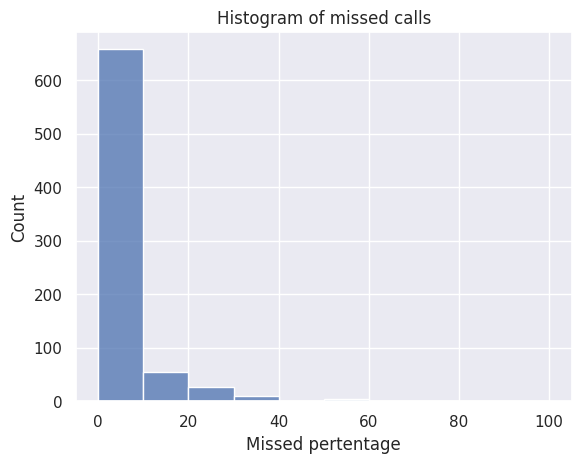

In [18]:
sns.set_theme(style='darkgrid')
plt.figure()
sns.histplot(data = missed_calls[missed_calls['operator_id']!=999], x = 'miss_percent', bins=10)
plt.xlabel('Missed pertentage')
plt.title('Histogram of missed calls')
plt.show()

Es bueno obsservar que la mayoria de operadores tiene un bajo porcentaje de llamadas perdidas, sin embargo esto el algo básico para el trabajo así que lo ideal es que todos los operadores estén cerca del cero. 

Clasificaré los resultados de la siguiente forma:
- Menos de 10%: Operdador bueno
- Entre 10% y 20%: Requiere atención
- Mayor a 20%: Ineficiente

Ya que voy a clasificar operadores según varios parámetros, crearé una función para usarla luego:

In [19]:
def rating_column(df, base_col, new_col, good, attention):
    ratings = []
    for value in df[base_col]:
        if value < good:
            ratings.append('good')
        elif good <= value <= attention:
            ratings.append('attention')
        else:
            ratings.append('inefficient')
    df[new_col] = ratings
    return df

In [20]:
rating_column(missed_calls,'miss_percent','miss_rating', 10, 20)

is_missed_call,operator_id,False,True,miss_percent,miss_rating
0,999.0,68.0,7202.0,99.065,inefficient
1,879896.0,21.0,0.0,0.000,good
2,879898.0,57.0,0.0,0.000,good
3,880020.0,7.0,0.0,0.000,good
4,880022.0,8.0,0.0,0.000,good
...,...,...,...,...,...
750,971102.0,4.0,0.0,0.000,good
751,971354.0,2.0,0.0,0.000,good
752,972412.0,1.0,0.0,0.000,good
753,972460.0,1.0,0.0,0.000,good


### Evaluar el tiempo de espera (duración de las llamadas)

Un usuario eficaz debe responder rápido y tener tiempos de espera reducidos.

In [21]:
hold_times = telecom.groupby('operator_id', as_index = False)['calls_count', 'call_duration', 'total_call_duration'].sum()
hold_times.head()

,operator_id,calls_count,call_duration,total_call_duration
0,999.0,104564,497685,1766770
1,879896.0,930,63862,76137
2,879898.0,7313,257391,361288
3,880020.0,45,2245,2525
4,880022.0,197,15147,18925


In [22]:
hold_times['hold_time'] = ((hold_times['total_call_duration'] - hold_times['call_duration']) / hold_times['calls_count']).round(3)
hold_times.head()

,operator_id,calls_count,call_duration,total_call_duration,hold_time
0,999.0,104564,497685,1766770,12.137
1,879896.0,930,63862,76137,13.199
2,879898.0,7313,257391,361288,14.207
3,880020.0,45,2245,2525,6.222
4,880022.0,197,15147,18925,19.178


In [23]:
hold_times['hold_time'].describe()

count    1093.000000
mean       16.465586
std         8.215440
min         0.000000
25%        11.500000
50%        15.782000
75%        20.006000
max        62.000000
Name: hold_time, dtype: float64

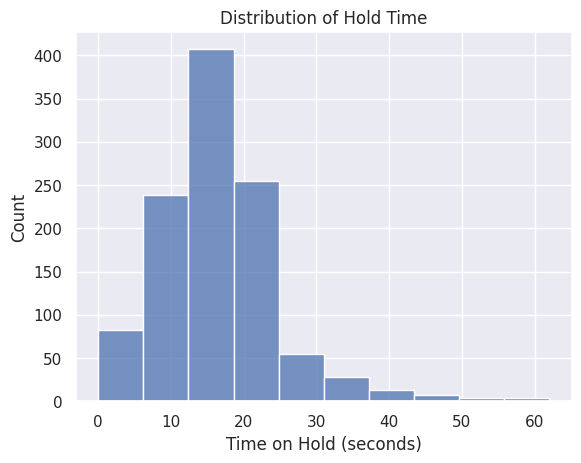

In [24]:
plt.figure()
sns.histplot(data = hold_times, x = 'hold_time',bins=10)
plt.xlabel('Time on Hold (seconds)')
plt.title('Distribution of Hold Time')
plt.show()

El promedio de espera es de poco más de 16 segundos por llamada, no es demasiado pero veamos si podemos mejorarlo con una clasificación un poco más rigurosa.

Con estos datos crearé los siguientes umbrales esperando además que los operadores se esfuercen por mejorar sus tiempos de espera y el promedio actual y con esto ser más eficientes:
- Menos de 16 segundos: Operador bueno
- De 16 a 30 segundos: Requiere atención
- Más de 30 segundos: Ineficiente

In [25]:
rating_column(hold_times, 'hold_time', 'hold_rating', 16, 30)

,operator_id,calls_count,call_duration,total_call_duration,hold_time,hold_rating
0,999.0,104564,497685,1766770,12.137,good
1,879896.0,930,63862,76137,13.199,good
2,879898.0,7313,257391,361288,14.207,good
3,880020.0,45,2245,2525,6.222,good
4,880022.0,197,15147,18925,19.178,attention
...,...,...,...,...,...,...
1088,972410.0,77,3777,5275,19.455,attention
1089,972412.0,61,3498,4548,17.213,attention
1090,972460.0,51,1218,1838,12.157,good
1091,973120.0,3,5,25,6.667,good


### Total llamadas diarias

Cuantas llamas hacen por día los operadores? Calculo el rango de tiempo activo de cada operador y promedio el total de llamadas por día.

In [26]:
total_calls = telecom.groupby('operator_id').agg(min_date=('date', 'min'),
                                                     max_date=('date', 'max'),
                                                     total_calls=('calls_count', 'sum')).reset_index()
total_calls['active_days'] = ((total_calls['max_date'] - total_calls['min_date']).dt.days) + 1
total_calls['daily_calls'] = (total_calls['total_calls'] / total_calls['active_days']).round(2)
total_calls.head()

,operator_id,min_date,max_date,total_calls,active_days,daily_calls
0,999.0,2019-08-02,2019-11-28,104564,119,878.69
1,879896.0,2019-08-02,2019-11-25,930,116,8.02
2,879898.0,2019-08-02,2019-11-28,7313,119,61.45
3,880020.0,2019-08-05,2019-10-03,45,60,0.75
4,880022.0,2019-08-05,2019-11-28,197,116,1.70


In [27]:
# Para esta parte eliminamos el operador ficticio pues incluye la suma de varios desconocidos y arroja un valor atípico alterando los datos
total_calls = total_calls[total_calls['operator_id']!=999]

In [28]:
total_calls['daily_calls'].describe()

count    1092.000000
mean       17.853993
std        48.567361
min         0.030000
25%         1.000000
50%         2.875000
75%        15.400000
max       770.040000
Name: daily_calls, dtype: float64

Filtro los valores más extremos para no alterar los datos, cabe destacar que estos valores son operadores con una inusual cantidad de llamadas por lo que reciben directamente una buena calificación

In [29]:
filter_calls = total_calls[total_calls['daily_calls'] < total_calls['daily_calls'].quantile(0.95)]
filter_calls['daily_calls'].describe()

count    1037.000000
mean       10.618197
std        17.218481
min         0.030000
25%         0.930000
50%         2.500000
75%        12.120000
max        78.070000
Name: daily_calls, dtype: float64

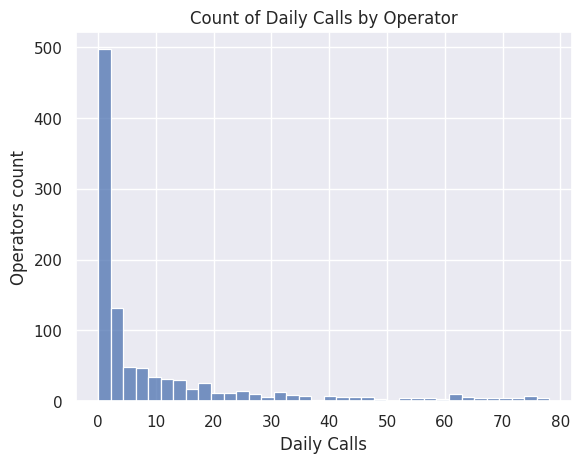

In [61]:
plt.figure()
sns.histplot(data = filter_calls, x = 'daily_calls')
plt.xlabel('Daily Calls')
plt.ylabel('Operators count')
plt.title('Count of Daily Calls by Operator')
plt.show()

Es preocupante que a pesar del filtrado, hay muchos operadores muy por debajo del promedio. Clasificaré de la siguiente forma:
- Más de 10 llamadas por día: Operador bueno.
- Entre 7 y 10: Atención.
- Menos de 7: Ineficiente.

In [31]:
rating_column(filter_calls, 'daily_calls', 'n_calls_rating', 7, 10)
#Aquí da resultados inversos así que los intercambio 
filter_calls['n_calls_rating'] = filter_calls['n_calls_rating'].replace({'inefficient': 'good', 'good': 'inefficient'})
filter_calls.head()

/tmp/ipykernel_49/233525943.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col] = ratings
/tmp/ipykernel_49/2416383343.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_calls['n_calls_rating'] = filter_calls['n_calls_rating'].replace({'inefficient': 'good', 'good': 'inefficient'})


,operator_id,min_date,max_date,total_calls,active_days,daily_calls,n_calls_rating
1,879896.0,2019-08-02,2019-11-25,930,116,8.02,attention
2,879898.0,2019-08-02,2019-11-28,7313,119,61.45,good
3,880020.0,2019-08-05,2019-10-03,45,60,0.75,inefficient
4,880022.0,2019-08-05,2019-11-28,197,116,1.70,inefficient
5,880026.0,2019-08-07,2019-11-28,2232,114,19.58,good


### Evaluar la duracion de llamadas 

Una llamada eficaz no puede ser muy corta ya que no alcanzaría a resolver el problema ni muy larga o puede crear frustración en los clientes. Por ello para este parámetro estableceré rangos de valores:
- En los extremos de 5% = Ineficiente
- En los extremos de 15% = Atención
- En el 70% central = Operador bueno

Anteriormente agrupé los datos necesarios para este análisis así que extraigo las columnas que necesito en esta parte.

In [32]:
call_duration = hold_times.iloc[:, :3]
call_duration['mean_duration'] = (call_duration['call_duration'] / call_duration['calls_count']).round(0)
call_duration.head()

,operator_id,calls_count,call_duration,mean_duration
0,999.0,104564,497685,5.0
1,879896.0,930,63862,69.0
2,879898.0,7313,257391,35.0
3,880020.0,45,2245,50.0
4,880022.0,197,15147,77.0


In [33]:
call_duration['mean_duration'].describe()

count    1093.000000
mean       74.015554
std        78.750247
min         0.000000
25%        31.000000
50%        59.000000
75%        93.000000
max      1306.000000
Name: mean_duration, dtype: float64

Reviso la distribución de los datos

<AxesSubplot:xlabel='mean_duration'>

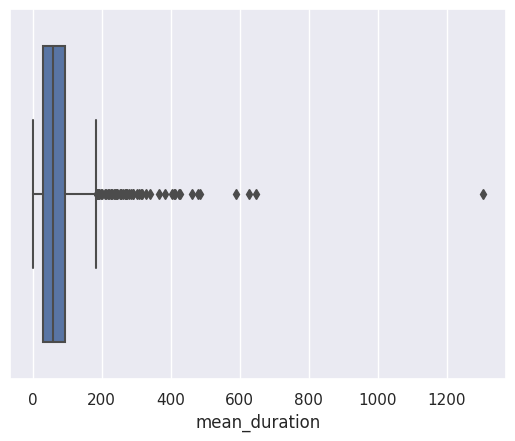

In [34]:
sns.boxplot(data=call_duration, x='mean_duration')

<AxesSubplot:>

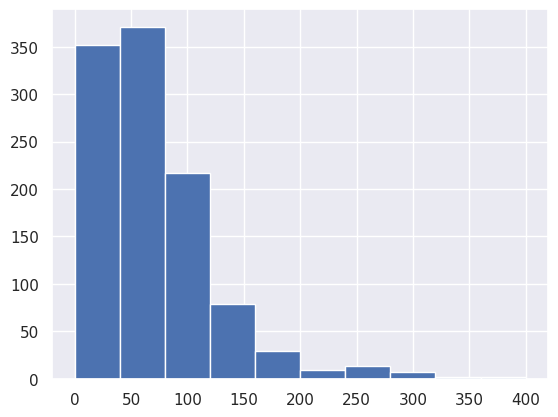

In [35]:
call_duration['mean_duration'].hist(range=(0,400))

Establezco los rangos y luego uso el mismo código de la función definida anteriormente pero la cambio para aceptar estos rangos en este caso particular.

In [36]:
q_5 = call_duration['mean_duration'].quantile(0.05)
q_15 = call_duration['mean_duration'].quantile(0.15)
q_85 = call_duration['mean_duration'].quantile(0.85)
q_95 = call_duration['mean_duration'].quantile(0.95)

ratings = []

for x in call_duration['mean_duration']:
    if x <= q_5 or x >= q_95:
        ratings.append('inefficient')
    elif (q_5 < x <= q_15) or (q_85 <= x < q_95):
        ratings.append('attention')
    else:
        ratings.append('good')

call_duration['duration_rating'] = ratings
call_duration.head()

,operator_id,calls_count,call_duration,mean_duration,duration_rating
0,999.0,104564,497685,5.0,inefficient
1,879896.0,930,63862,69.0,good
2,879898.0,7313,257391,35.0,good
3,880020.0,45,2245,50.0,good
4,880022.0,197,15147,77.0,good


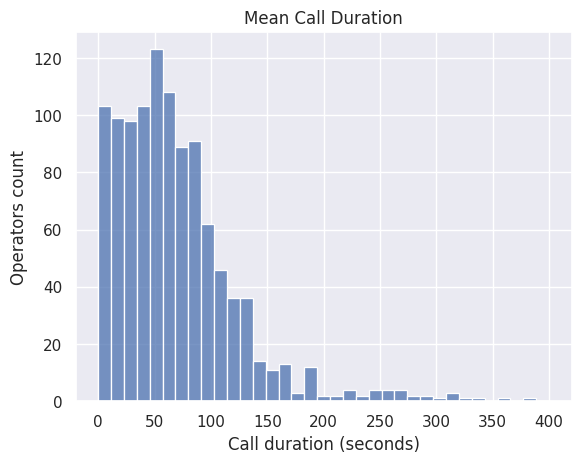

In [65]:
plt.figure()
sns.histplot(data= call_duration, x = 'mean_duration', binrange=(0,400))
plt.xlabel('Call duration (seconds)')
plt.ylabel('Operators count')
plt.title('Mean Call Duration')
plt.show()

### Combinar y sumar las puntuaciones

Ya con varios argumentos definidos para evaluar, junto los resultados en una tabla

In [37]:
missed_calls

is_missed_call,operator_id,False,True,miss_percent,miss_rating
0,999.0,68.0,7202.0,99.065,inefficient
1,879896.0,21.0,0.0,0.000,good
2,879898.0,57.0,0.0,0.000,good
3,880020.0,7.0,0.0,0.000,good
4,880022.0,8.0,0.0,0.000,good
...,...,...,...,...,...
750,971102.0,4.0,0.0,0.000,good
751,971354.0,2.0,0.0,0.000,good
752,972412.0,1.0,0.0,0.000,good
753,972460.0,1.0,0.0,0.000,good


In [38]:
hold_times

,operator_id,calls_count,call_duration,total_call_duration,hold_time,hold_rating
0,999.0,104564,497685,1766770,12.137,good
1,879896.0,930,63862,76137,13.199,good
2,879898.0,7313,257391,361288,14.207,good
3,880020.0,45,2245,2525,6.222,good
4,880022.0,197,15147,18925,19.178,attention
...,...,...,...,...,...,...
1088,972410.0,77,3777,5275,19.455,attention
1089,972412.0,61,3498,4548,17.213,attention
1090,972460.0,51,1218,1838,12.157,good
1091,973120.0,3,5,25,6.667,good


In [39]:
total_calls

,operator_id,min_date,max_date,total_calls,active_days,daily_calls
1,879896.0,2019-08-02,2019-11-25,930,116,8.02
2,879898.0,2019-08-02,2019-11-28,7313,119,61.45
3,880020.0,2019-08-05,2019-10-03,45,60,0.75
4,880022.0,2019-08-05,2019-11-28,197,116,1.70
5,880026.0,2019-08-07,2019-11-28,2232,114,19.58
...,...,...,...,...,...,...
1088,972410.0,2019-11-27,2019-11-28,77,2,38.50
1089,972412.0,2019-11-27,2019-11-28,61,2,30.50
1090,972460.0,2019-11-27,2019-11-28,51,2,25.50
1091,973120.0,2019-11-27,2019-11-27,3,1,3.00


In [40]:
op_rating = missed_calls.iloc[:, [0, -1]].merge(hold_times.iloc[:, [0, -1]], on='operator_id', how='outer')
op_rating = op_rating.merge(filter_calls.iloc[:, [0, -1]], on = 'operator_id', how = 'outer')
op_rating = op_rating.merge(call_duration.iloc[:, [0, -1]], on = 'operator_id', how = 'outer')
op_rating

,operator_id,miss_rating,hold_rating,n_calls_rating,duration_rating
0,999.0,inefficient,good,NaN,inefficient
1,879896.0,good,good,attention,good
2,879898.0,good,good,good,good
3,880020.0,good,good,inefficient,good
4,880022.0,good,attention,inefficient,good
...,...,...,...,...,...
1088,970484.0,NaN,good,inefficient,attention
1089,970486.0,NaN,good,inefficient,good
1090,972408.0,NaN,good,inefficient,good
1091,972410.0,NaN,attention,good,good


In [41]:
missed_calls

is_missed_call,operator_id,False,True,miss_percent,miss_rating
0,999.0,68.0,7202.0,99.065,inefficient
1,879896.0,21.0,0.0,0.000,good
2,879898.0,57.0,0.0,0.000,good
3,880020.0,7.0,0.0,0.000,good
4,880022.0,8.0,0.0,0.000,good
...,...,...,...,...,...
750,971102.0,4.0,0.0,0.000,good
751,971354.0,2.0,0.0,0.000,good
752,972412.0,1.0,0.0,0.000,good
753,972460.0,1.0,0.0,0.000,good


In [42]:
op_rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1093 entries, 0 to 1092
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   operator_id      1093 non-null   float64
 1   miss_rating      755 non-null    object 
 2   hold_rating      1093 non-null   object 
 3   n_calls_rating   1037 non-null   object 
 4   duration_rating  1093 non-null   object 
dtypes: float64(1), object(4)
memory usage: 51.2+ KB


In [43]:
#Agrego la calificación de los operadores "filtrados" anteriormente
op_rating = op_rating.fillna('good')

In [44]:
op_rating

,operator_id,miss_rating,hold_rating,n_calls_rating,duration_rating
0,999.0,inefficient,good,good,inefficient
1,879896.0,good,good,attention,good
2,879898.0,good,good,good,good
3,880020.0,good,good,inefficient,good
4,880022.0,good,attention,inefficient,good
...,...,...,...,...,...
1088,970484.0,good,good,inefficient,attention
1089,970486.0,good,good,inefficient,good
1090,972408.0,good,good,inefficient,good
1091,972410.0,good,attention,good,good


Cambio los resultados por valores numéricos para sumar la puntuación final y en base a eso se asigna cada operador a una categoría descrita a continuación:
Puntaje de 0 a 20 en la que 
- 16 o más puntos (Good): No es ineficiente en ningún area, como mucho requiere atención en alguna.
- Entre 11 y 15 (Attention): En general no es particularmente malo pero puede mejorar.
- Hasta 10 (Inefficient): Operadores con muy mal desempeño, requieren atención inmediata. 

In [45]:
op_score = op_rating
score_map = {'good': 5, 'attention': 2, 'inefficient': 0}
op_score = op_score.replace(score_map)
op_score['score'] = op_score[['miss_rating', 'hold_rating', 'n_calls_rating', 'duration_rating']].sum(axis=1)

final_rating = []

for x in op_score['score']:
    if x >= 16:
        final_rating.append('good')
    elif 11 <= x < 16:
        final_rating.append('attention')
    else:
        final_rating.append('inefficient')

op_score['final_rating'] = final_rating
op_score.head()

,operator_id,miss_rating,hold_rating,n_calls_rating,duration_rating,score,final_rating
0,999.0,0,5,5,0,10,inefficient
1,879896.0,5,5,2,5,17,good
2,879898.0,5,5,5,5,20,good
3,880020.0,5,5,0,5,15,attention
4,880022.0,5,2,0,5,12,attention


Ya con la calificación final podemos trazar histogramas para ver la distribución 

In [46]:
op_score['final_rating'].value_counts()

attention      563
good           294
inefficient    236
Name: final_rating, dtype: int64

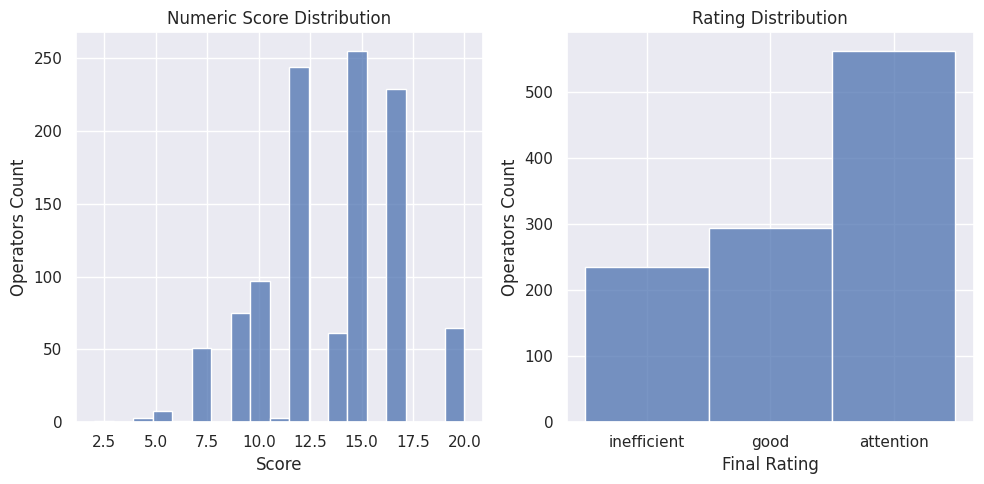

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(data = op_score, x = 'score', ax = axs[0])
axs[0].set_title('Numeric Score Distribution')
axs[0].set_xlabel('Score')
axs[0].set_ylabel('Operators Count')

sns.histplot(data = op_score, x = 'final_rating', ax = axs[1])
axs[1].set_title('Rating Distribution')
axs[1].set_xlabel('Final Rating')
axs[1].set_ylabel('Operators Count')

plt.tight_layout()
plt.show()

La mayoría de operadores tienen espacio para mejorar pero es bueno ver que el grupo con mal desempeño es también el más pequeño.

Luego de tener la clasificación lista puedo proceder a crear hipótesis sobre el comportamiento por desempeño

HIPOTESIS 1: USUARIOS DE PLAN A INTERACTUAN CON MAS OPERADORES EFICIENTES
H0: distribucion de ambos planes es similar
H1: un plan tiene mejor resultado que otro

HIPOTESIS 2: OPERADORES EFICIENTES HACEN MAS LLAMADAS EXTERNAS QUE LOS MALOS
H0: No hay diferencia
H1: Hay un grupo de operadores que realiza menos llamadas externas

## Pruebas de Hipótesis

### Hipótesis #1: Buenos operadores hacen más llamadas externas que los ineficientes.
Hipótesis nula: No hay diferencia significativa en la cantidad de llamadas externas realizadas entre ambos grupos de operadores.

Hipótesis alternativa: Los operadores ineficientes realizan menos llamadas externas que los eficientes.

In [48]:
# UMBRAL DE ALPHA EN 5%
alpha=0.05

In [49]:
rating_tlc = telecom.merge(op_score[['operator_id','final_rating']], on ='operator_id', how='left')

out_calls = rating_tlc[rating_tlc['direction'] == 'out']

calls_summary = out_calls.groupby('operator_id')['calls_count'].sum().reset_index()
calls_summary = calls_summary.merge(op_score[['operator_id','final_rating']], on='operator_id', how='left')

# Separar por clasificación
good_operators = calls_summary[calls_summary['final_rating'] == 'good']
inefficient_operators = calls_summary[calls_summary['final_rating'] == 'inefficient']

In [50]:
# Levene para evaluar varianzas 
levene_stat, levene_p_value = levene(good_operators['calls_count'], inefficient_operators['calls_count'])
print(f'Estadístico de Levene: {levene_stat}')
print(f'Valor p de Levene: {levene_p_value}')

if levene_p_value < alpha:
    print("Las varianzas son significativamente diferentes.")
else:
    print("No hay evidencia suficiente para afirmar que las varianzas son diferentes.")

Estadístico de Levene: 35.975455509555154
Valor p de Levene: 4.1599001756503035e-09
Las varianzas son significativamente diferentes.


Prueba Mann-Whitney U

In [51]:
u_stat, mannwhitney_p_value = mannwhitneyu(good_operators['calls_count'], inefficient_operators['calls_count'], alternative='greater')

print(f'Estadístico U: {u_stat}')
print(f'Valor p de Mann-Whitney: {mannwhitney_p_value}')

if mannwhitney_p_value < alpha:
    print("Rechazamos la H0, los operadores buenos realizan significativamente más llamadas.")
else:
    print("No hay suficiente evidencia para afirmar que hay diferencia en las llamadas de ambos grupos.")

Estadístico U: 42369.0
Valor p de Mann-Whitney: 1.3120492578479738e-56
Rechazamos la H0, los operadores buenos realizan significativamente más llamadas.


Es un resultado que no sorprende ya que entra dentro de lo que es esperado de un operador eficaz.

### Hipótesis #2: Los operadores eficientes favorecen a algún plan en particular.
H0: Todos los planes interactúan de forma similar con cada tipo de operador.

H1: Al menos un plan interactúa más con operadores eficaces.


Hay tres planes así que usaré la prueba ANOVA para evaluar como interactúan con usuarios buenos.

Es importante resaltar que las muestras no son parejas entre si ni son muy amplias así que los resultados podrían cambiar con mayor cantidad de datos.

In [52]:
plan_count = clients['tariff_plan'].value_counts()
plan_dict = dict(plan_count)

In [53]:
plan_tlc = rating_tlc.merge(clients[['user_id','tariff_plan']], on='user_id', how='left')
good_interactions = plan_tlc[plan_tlc['final_rating'] == 'good']

# Agrupar por plan y contar las interacciones
plan_a = good_interactions[good_interactions['tariff_plan'] == 'A']['calls_count']
plan_b = good_interactions[good_interactions['tariff_plan'] == 'B']['calls_count']
plan_c = good_interactions[good_interactions['tariff_plan'] == 'C']['calls_count']

# Aplicar ANOVA
f_stat, p_value = f_oneway(plan_a, plan_b, plan_c)
print(f'Estadístico F: {f_stat}')
print(f'Valor p: {p_value}')

if p_value < alpha:
    print("Se rechaza la hipótesis nula. Hay diferencias significativas entre los planes.")
else:
    print("No hay suficiente evidencia para rechazar H0")


Estadístico F: 149.7773672106206
Valor p: 2.721535337357596e-65
Se rechaza la hipótesis nula. Hay diferencias significativas entre los planes.


Esto indica que los operadores eficaces suelen atender a un plan en particular. Averiguaré cual es.

In [54]:
plan_count = clients['tariff_plan'].value_counts()
plan_dict = dict(plan_count)

In [55]:
plan_dict

{'C': 395, 'B': 261, 'A': 76}

In [56]:
interaction = good_interactions.groupby('tariff_plan')['user_id'].count().reset_index()
interaction

,tariff_plan,user_id
0,A,5822
1,B,5832
2,C,8350


In [57]:
interaction

,tariff_plan,user_id
0,A,5822
1,B,5832
2,C,8350


Text(0.5, 1.0, 'Llamadas de operadores eficaces por plan')

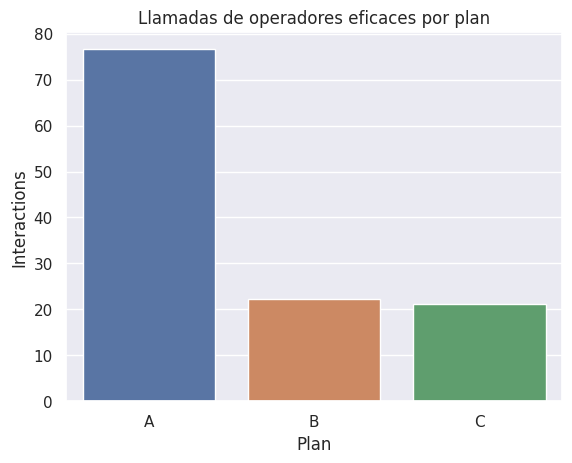

In [66]:
interaction['plan_count'] = interaction['tariff_plan'].map(plan_dict)
interaction['prop_interactions'] = interaction['user_id'] / interaction['plan_count']

plt.figure()
sns.barplot(data = interaction, x = 'tariff_plan', y = 'prop_interactions')
plt.xlabel('Plan')
plt.ylabel('Interactions')
plt.title('Llamadas de operadores eficaces por plan')

A pesar de que el plan A es el que tiene menos usuarios, es proporcionalmente el que más interactua con buenos operadores.

## Conclusiones y recomendaciones

Se ha logrado el objetivo de categorizar el rendimiento de operadores para identificar a los deficientes así como los que están en riesgo y se establecieron umbrales de lo que es un operador eficaz para aspirar a esas métricas.

### Recomendaciones:
**Mejorar la capacitación:**
Se deben implementar programas de capacitación continua para los operadores, con refuerzo en los "ineficientes"para ayudar a mejorar su rendimiento y aumentar la satisfacción del cliente.

**Evaluar el servicio al cliente del plan A:**
Dado que los usuarios del plan A tienen mayor interacción con operadores eficientes, se recomienda evaluar las razones detrás de esto. Podría ser útil recopilar retroalimentación de los usuarios de este plan para identificar áreas de mejora.

**Monitoreo continuo y mejora:**
Implementar un sistema de monitoreo continuo para evaluar el rendimiento de los operadores. Esto incluiría métricas de eficiencia, tiempos de respuesta y satisfacción del cliente. Con estos datos, se pueden hacer ajustes en tiempo real para optimizar la atención al cliente.

**Incentivos por buen rendimiento:**
Considerar la implementación de promociones o incentivos específicos para los operadores con buena evaluación para fomentar interacciones más efectivas y la adopción de mejores prácticas.


El análisis realizado sugiere que existen áreas significativas de mejora en la interacción entre los operadores y los usuarios. Implementar las recomendaciones proporcionadas no solo puede ayudar a identificar operadores ineficaces, sino también a mejorar la experiencia del cliente en general, lo que es fundamental para el éxito a largo plazo en la industria de telecomunicaciones.

LINK A PRESENTACIóN: https://drive.google.com/file/d/1w2WHftugqI0TsIefJUiucbQGRyMMpn5e/view?usp=sharing